In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import cv2
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import supervision as sv
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO, LABEL_PROJECTION_MAP
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [12]:
model_size_dict = {
    'base': {
        'config': '04_07_14_49/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/04_07_14_49/checkpoints/checkpoint.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
amp_type = torch.bfloat16 if device == 'cuda' else torch.float16
submodel, object_labels, _, loss = build_sam2former(config, ck, device=device)
print(device)

Operation divide already registered
OmegaConf resolved successfully
cpu


In [13]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("after", after)
    print(torch.all(after == 0))

before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  .

after Parameter containing:
tensor([[ 2.1465e-02, -5.4990e-03, -1.0207e-02,  ..., -1.3025e-02,
          2.0763e-02,  2.7085e-03],
        [ 2.4830e-02, -6.5351e-03, -8.9704e-03,  ..., -1.1903e-02,
          1.5509e-02, -2.8072e-05],
        [-1.8246e-03, -9.4041e-04, -9.3904e-03,  ..., -1.6708e-02,
          9.9004e-03,  1.6914e-03],
        ...,
        [-2.4096e-03,  8.3106e-03, -1.2964e-02,  ...,  1.3112e-04,
          1.3297e-02,  1.2967e-02],
        [-3.1994e-02, -1.2677e-02,  8.5263e-03,  ...,  1.3057e-02,
          1.4855e-03,  1.5871e-02],
        [-1.0125e-02, -2.1476e-02,  5.6368e-03,  ...,  1.1847e-02,
         -3.0786e-02, -3.3325e-03]], requires_grad=True)
tensor(False)
after Parameter containing:
tensor([[ 3.6056e-03,  7.3002e-03, -4.6736e-04,  ..., -7.1990e-03,
         -2.4689e-02,  5.1099e-03],
        [-1.7691e-05,  4.2531e-04, -4.0276e-03,  ...,  1.7229e-03,
         -2.0970e-02,  8.6589e-03],
        [-4.7948e-03, -3.2236e-03,  7.4105e-03,  ..., -1.3237e-02,
     

In [14]:
# Dataset
len_video = 3
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Lenght of the dataset! 132


In [15]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False
sample_idx = 100
test_loader = test_dataset.get_loader()
with torch.no_grad():
    submodel.train()
    for idx, batch in enumerate(test_loader):
        if idx < sample_idx:
            continue
        elif idx > sample_idx:
            break
        batched_video_data_val = batch[0].to(device)
        seg_mask = batch[1]  # List of PIL Image for debug
        masks_val = batch[0].masks.to(device)
        with autocast(device_type=device, dtype=amp_type):
            all_frame_outputs_val = submodel(batched_video_data_val)

In [16]:
# batch = batch[0]
# batch_size = len(batch.img_batch)
# key = batch.dict_key  # key for dataset
# targets = []

# for i in range(batch_size):
#     # dim=2 video_id, obj_id, frame_id
#     xx, yy = torch.where(batch.metadata.unique_objects_identifier[:,:,2] == i)
#     obj_id = batch.metadata.unique_objects_identifier[xx,yy,1]
#     targets.append({
#         "masks": batch.masks[i],
#         "labels": obj_id,
#     })
    
# loss[key](all_frame_outputs_val, targets)

In [27]:
# Define the batch index to visualize
batch_idx = 0

# Predicted Logits
pred_logits = all_frame_outputs_val[batch_idx]['pred_logits'][0].cpu()  # B, 1, Query, Labels -> Query, Labels
best_probs = pred_logits.softmax(dim=-1).max(dim=-1)
print("Predicted class probabilty", best_probs)

# GT Labels
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]
print("GT labels", gt_labels)

Predicted class probabilty torch.return_types.max(
values=tensor([1.], dtype=torch.float16),
indices=tensor([0]))
GT labels tensor([[0],
        [0],
        [0]])


In [29]:
all_frame_outputs_val[batch_idx]['pred_logits']
pred_logits.softmax(dim=-1)
pred_logits.softmax(dim=-1).max(dim=-1)

batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

tensor([[0],
        [0],
        [0]])

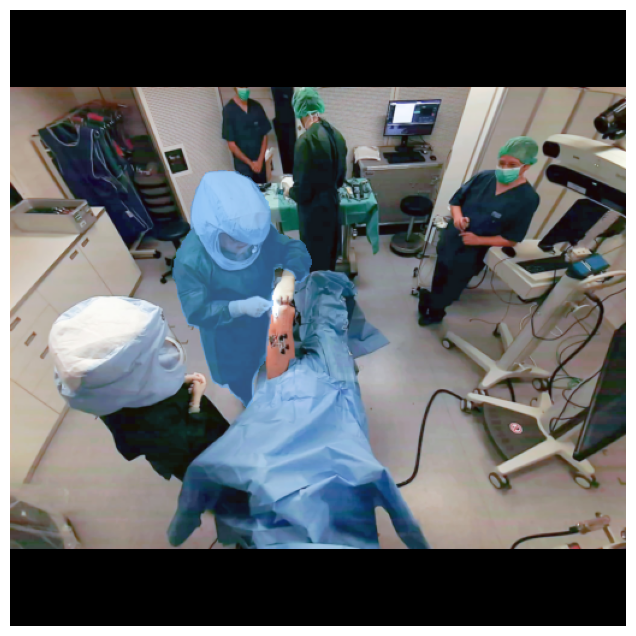

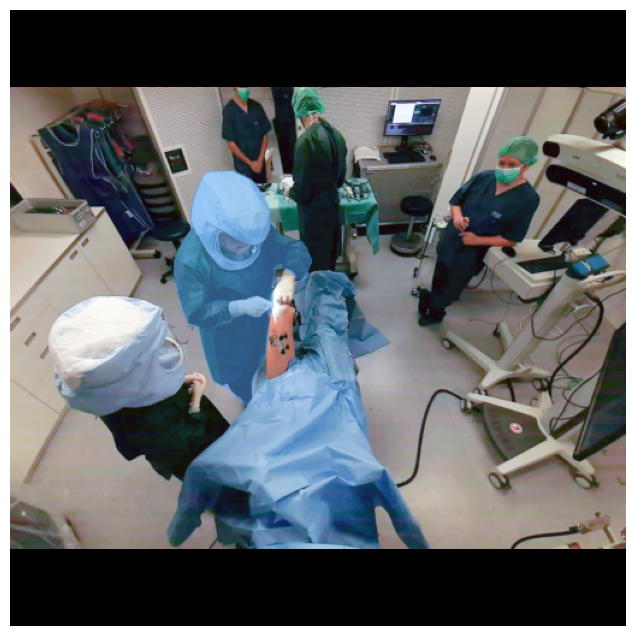

In [30]:
def get_color_map():
    color_map = []
    for k, v in LABEL_PROJECTION_MAP.items():
        r, g, b = v['color']
        color_map.append(sv.Color(r,g,b))
    color_map = sv.ColorPalette(colors=color_map)
    return color_map

# Get color map
color_map = get_color_map()

# Unnormalize the image
image = batched_video_data_val.img_batch[batch_idx].squeeze(0)
unnormalized_image = toPILimage(revert_transform(image))

# GT masks
gt_mask = masks_val[batch_idx].cpu().numpy()
gt_class_id = gt_labels[batch_idx].cpu().numpy()
empty_bboxes = np.array([[0, 0, 0, 0]] * len(gt_class_id))

# Gt Annotated Frame 
gt_detections = sv.Detections(xyxy=empty_bboxes, mask=gt_mask, class_id=gt_class_id)
mask_annotator = sv.MaskAnnotator(color=color_map)
gt_annotated_frame = mask_annotator.annotate(
    scene=unnormalized_image.copy(),
    detections=gt_detections
)
sv.plot_image(gt_annotated_frame, size=(8,8))

# Prediction masks
pred_mask = (all_frame_outputs_val[batch_idx]['pred_masks_high_res'][0].sigmoid() > 0.5).bool().numpy()
pred_class_ids = best_probs.indices.numpy().astype(np.int32)
empty_bboxes = np.array([[0, 0, 0, 0]] * len(pred_class_ids))

# Prediction Annotated Frame
pred_detections = sv.Detections(xyxy=empty_bboxes, mask=pred_mask, class_id=pred_class_ids)
mask_annotator = sv.MaskAnnotator(color=color_map)
pred_annotated_frame = mask_annotator.annotate(
    scene=unnormalized_image.copy(),
    detections=pred_detections
)
sv.plot_image(pred_annotated_frame, size=(8,8))


IndexError: index 1 is out of bounds for dimension 0 with size 1

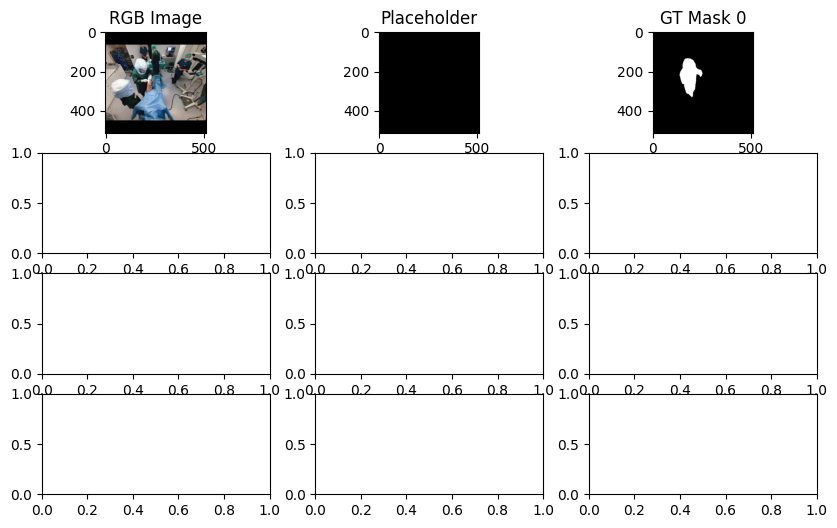

In [31]:
gt_mask = masks_val[batch_idx].cpu()
black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(black_placeholder, cmap='gray')
axes[0, 1].set_title("Placeholder")

axes[0, 2].imshow(gt_mask[0], cmap='gray')
axes[0, 2].set_title("GT Mask 0")

# Second row (GT gt_mask)
axes[1, 0].imshow(gt_mask[1], cmap='gray')
axes[1, 0].set_title("GT Mask 1")

axes[1, 1].imshow(gt_mask[2], cmap='gray')
axes[1, 1].set_title("GT Mask 2")

axes[1, 2].imshow(gt_mask[3], cmap='gray')
axes[1, 2].set_title("GT Mask 3")

# Third row (GT gt_mask)
axes[2, 0].imshow(gt_mask[4], cmap='gray')
axes[2, 0].set_title("GT Mask 4")

axes[2, 1].imshow(gt_mask[5], cmap='gray')
axes[2, 1].set_title("GT Mask 5")

axes[2, 2].imshow(gt_mask[6], cmap='gray')
axes[2, 2].set_title("GT Mask 6")

# Fourth row (GT gt_mask)
axes[3, 0].imshow(gt_mask[7], cmap='gray')
axes[3, 0].set_title("GT Mask 7")

axes[3, 1].imshow(gt_mask[8], cmap='gray')
axes[3, 1].set_title("GT Mask 8")

axes[3, 2].imshow(gt_mask[9], cmap='gray')
axes[3, 2].set_title("GT Mask 9")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

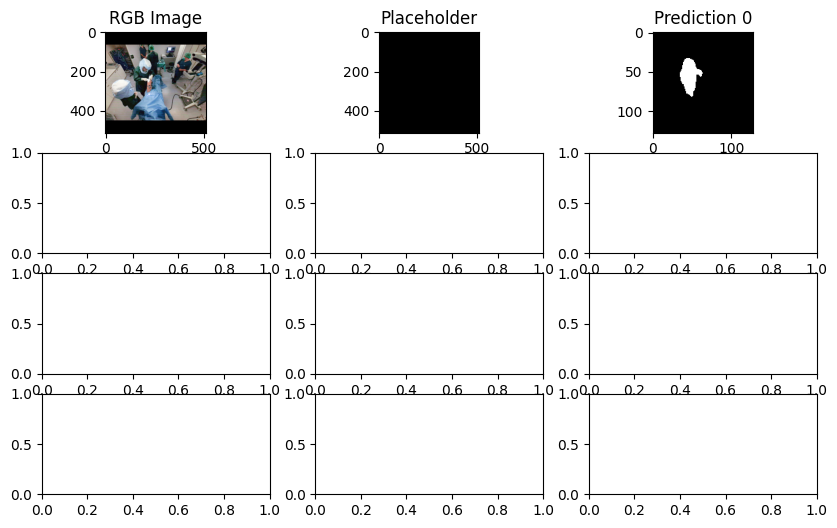

In [ ]:
black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder
pred_mask = (all_frame_outputs_val[batch_idx]['pred_masks'][0].sigmoid() > 0.5).bool().numpy()

# Create figure and subplots
fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(black_placeholder, cmap='gray')
axes[0, 1].set_title("Placeholder")

axes[0, 2].imshow(pred_mask[0], cmap='gray')
axes[0, 2].set_title("Prediction 0")

# Second row (Predictions)
axes[1, 0].imshow(pred_mask[1], cmap='gray')
axes[1, 0].set_title("Prediction 1")

axes[1, 1].imshow(pred_mask[2], cmap='gray')
axes[1, 1].set_title("Prediction 2")

axes[1, 2].imshow(pred_mask[3], cmap='gray')
axes[1, 2].set_title("Prediction 3")

# Third row (Predictions)
axes[2, 0].imshow(pred_mask[4], cmap='gray')
axes[2, 0].set_title("Prediction 4")

axes[2, 1].imshow(pred_mask[5], cmap='gray')
axes[2, 1].set_title("Prediction 5")

axes[2, 2].imshow(pred_mask[6], cmap='gray')
axes[2, 2].set_title("Prediction 6")

# Fourth row (Predictions)
axes[3, 0].imshow(pred_mask[7], cmap='gray')
axes[3, 0].set_title("Prediction 7")

axes[3, 1].imshow(pred_mask[8], cmap='gray')
axes[3, 1].set_title("Prediction 8")

axes[3, 2].imshow(pred_mask[9], cmap='gray')
axes[3, 2].set_title("Prediction 9")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()